In [18]:
from asammdf import MDF, Signal
from asammdf.blocks.types import DbcFileType, BusType, StrPath
from pathlib import Path
import requests
from datetime import datetime, timedelta
from time import sleep
import json
from collections.abc import Iterable
from collections import defaultdict
import cantools
import numpy as np
import pandas as pd
from sending import *
import pickle
import os
from sending import *

d65_onedrive_files = Path.joinpath(
    Path(r"C:/") if os.name == 'nt' else Path(r"/mnt/c/",r"Users/CARIM/Epiroc/Rig Crew - Private - General/5. Testing/CANEdge")
)

d65_d_files = Path.joinpath(
    Path(r"D:/") if os.name == 'nt' else r"/mnt/d/",r"D65CANEdgeFiles"
)

lower_id = "5A72CE4C"
upper_id = "6C1D6B77"

lower_files = list((d65_onedrive_files / "Lower").rglob('*.[mM][fF]4'))
upper_files = list((d65_onedrive_files / "Upper").rglob('*.[mM][fF]4'))
print(f'Found {len(lower_files)} MF4 files in lower.')
print(f'Found {len(upper_files)} MF4 files in upper.')

Found 379 MF4 files in lower.
Found 360 MF4 files in upper.


In [19]:
with open('d65_canedge_file_data.pkl', 'rb') as f:
    df = pickle.load(f)

print(df.head())
print(df.tail())

   Group                                               File  \
0  Lower  /mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...   
1  Lower  /mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...   
2  Lower  /mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...   
3  Lower  /mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...   
4  Lower  /mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...   

                  Start Time                          End Time  
0  2025-06-21T05:46:13+00:00  2025-06-21T09:59:59.978150+00:00  
1  2025-06-21T05:46:13+00:00  2025-06-21T11:23:00.516950+00:00  
2  2025-06-21T05:46:13+00:00  2025-06-21T11:29:59.980300+00:00  
3  2025-06-21T05:46:13+00:00  2025-06-21T11:52:59.812950+00:00  
4  2025-06-21T05:46:13+00:00  2025-06-21T11:59:59.968000+00:00  
     Group                                               File  \
734  Upper  /mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...   
735  Upper  /mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...   
736  Upper  /mnt/c/Users/CARIM/Epiro

In [20]:
with open('d65_canedge_file_data.pkl', 'rb') as f:
    df = pickle.load(f)

def parse_file(group: str, files: list[Path]):
    print(f"{group} files...")
    _count = len(files)
    print(f" Processing {0:4d}/{_count:4d} [{0:3d}%] ...", end='\r', flush=True)
    for i, file in enumerate(files):
        _file = file.as_posix()
        if os.name == 'nt':
            _file = _file.replace('C:/', '/mnt/c/')
        
        if _file in df['File'].values:
            # File is already processed
            # If the file is on the list but no longer exists, remove it from the DataFrame
            if not file.exists():
                df.drop(df[df['File'] == _file].index, inplace=True)
            continue
    
        try:
            with MDF(Path(file), process_bus_logging=False) as mdf:
                _split = _file.split('/')
                _disp = "/".join(_split[_split.index(group):])
                print(f" Processing {i:4d}/{_count:4d} [{int(round(100*i/_count)):3d}%] .../{_disp}", end='\r', flush=True)
                start_date = mdf.start_time
                end_date = datetime.fromtimestamp(0, tz=start_date.tzinfo)  # Initialize to epoch in the same timezone
                for ch in mdf.iter_channels():
                    if len(ch.timestamps):
                        if (end_date + timedelta(seconds=ch.timestamps[-1])) > end_date:
                            end_date = mdf.start_time + timedelta(seconds=ch.timestamps[-1])
                
                df.loc[len(df)] = [group, str(file), start_date.isoformat(), end_date.isoformat()]
            
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    print (f"{group} files ... Complete!", flush=True)

parse_file('Lower', lower_files)
parse_file('Upper', upper_files)

Lower files...
Lower files ... Complete!0%] .../Lower/5A72CE4C/00001304/00000001.MF4
Upper files...
Upper files ... Complete!9%] .../Upper/6C1D6B77/00001149/00000001.MF4


In [10]:
df.tail()

,Group,File,Start Time,End Time
742,Lower,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-06-21T05:46:13+00:00,2025-06-21T09:59:59.978150+00:00
1,Lower,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-06-21T05:46:13+00:00,2025-06-21T11:23:00.516950+00:00
2,Lower,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-06-21T05:46:13+00:00,2025-06-21T11:29:59.980300+00:00
3,Lower,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-06-21T05:46:13+00:00,2025-06-21T11:52:59.812950+00:00
4,Lower,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-06-21T05:46:13+00:00,2025-06-21T11:59:59.968000+00:00


In [11]:
df.tail()

,Group,File,Start Time,End Time
734,Upper,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-07-16T17:53:21+00:00,2025-07-16T17:57:38.647150+00:00
743,Upper,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-07-16T17:57:45+00:00,2025-07-16T17:59:59.372650+00:00
744,Upper,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-07-16T17:57:45+00:00,2025-07-16T18:03:48.200950+00:00
745,Upper,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-07-16T18:04:12+00:00,2025-07-16T18:10:21.469750+00:00
746,Upper,/mnt/c/Users/CARAL/Epiroc/Rig Crew - Private -...,2025-07-16T18:21:34+00:00,2025-07-16T18:28:09.375100+00:00


In [23]:
import pickle

# Pickle the dataframe to a file
with open('d65_canedge_file_data.pkl', 'wb') as f:
    pickle.dump(df, f)

print('DataFrame pickled to d65_canedge_file_data.pkl')

<Response [403]> 403 Forbidden <!--# 1N86vF47S30655qRqDs6D2jsPPDN86vF6fZ8vPWd-->
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3c.org/TR/1999/REC-html401-19991224/loose.dtd">
<html>
<head>
<meta name="description" content="Zscaler makes the internet safe for businesses by protecting their employees from malware, viruses, and other security threats.">
<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1">
<title>Internet Security by Zscaler</title>
<script language="JavaScript">var defLang = 'en_US'</script>
<!--Epiroc-->
<style type="text/css">
body {
background-color:#e3e3e3;
font-family:Arial, sans-serif;
font-size:12px;
color:#4B4F54;
}
a {
cursor:pointer;
text-decoration:none;
color:#009dd0;
}
table {
margin-top:10px;
}
td table {
margin-top:0;
text-align:center;
}
img {
max-height:75px;
max-width:430px;
}
.pg {
position:absolute;
top:0;
bottom:0;
left:0;
right:0;
overflo
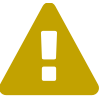

In [11]:
resp = requests.get('http://localhost:8428/api/v1/status/active_queries')
print(resp, resp.status_code, resp.reason, resp.text)

In [15]:
df[(pd.to_datetime(df['End Time']) > pd.Timestamp(2025,7,16, tz='UTC')) & (df.Group == 'Upper')]

,Group,File,Start Time,End Time
734,Upper,/mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...,2025-07-16T17:53:21+00:00,2025-07-16T17:57:38.647150+00:00
735,Upper,/mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...,2025-07-16T17:57:45+00:00,2025-07-16T17:59:59.372650+00:00
736,Upper,/mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...,2025-07-16T17:57:45+00:00,2025-07-16T18:03:48.200950+00:00
737,Upper,/mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...,2025-07-16T18:04:12+00:00,2025-07-16T18:10:21.469750+00:00
738,Upper,/mnt/c/Users/CARIM/Epiroc/Rig Crew - Private -...,2025-07-16T18:21:34+00:00,2025-07-16T18:28:09.375100+00:00


In [16]:
df['End Time'].size

739

In [19]:
from canmatrix.formats.dbc import load

dbc = None

with open(r"/home/default/work/ttc500_shell/apps/ttc_590_d65_ctrl_app/dbc/brightloop/d65_brightloops.dbc", 'r') as f:
    dbc = load(f)

print(dbc)

error with line no: 1
VERSION "ae3c"

error with line no: 4
NS_ : 

error with line no: 5
	NS_DESC_

error with line no: 6
	CM_

error with line no: 7
	BA_DEF_

error with line no: 8
	BA_

error with line no: 9
	VAL_

error with line no: 10
	CAT_DEF_

error with line no: 11
	CAT_

error with line no: 12
	FILTER

error with line no: 13
	BA_DEF_DEF_

error with line no: 14
	EV_DATA_

error with line no: 15
	ENVVAR_DATA_

error with line no: 16
	SGTYPE_

error with line no: 17
	SGTYPE_VAL_

error with line no: 18
	BA_DEF_SGTYPE_

error with line no: 19
	BA_SGTYPE_

error with line no: 20
	SIG_TYPE_REF_

error with line no: 21
	VAL_TABLE_

error with line no: 22
	SIG_GROUP_

error with line no: 23
	SIG_VALTYPE_

error with line no: 24
	SIGTYPE_VALTYPE_

error with line no: 25
	BO_TX_BU_

error with line no: 26
	BA_DEF_REL_

error with line no: 27
	BA_REL_

error with line no: 28
	BA_DEF_DEF_REL_

error with line no: 29
	BU_SG_REL_

error with line no: 30
	BU_EV_REL_

error with line no: 31

In [4]:
directory = Path("D:/D65CANEdgeFiles/Upper/20250725_DCHVGUI/mf4")
if not directory.exists():
    print(f"Directory {directory} does not exist.")
else:
    _d65_loc = Path.joinpath(
            Path.home(), "ttc500_shell/apps/ttc_590_d65_ctrl_app/dbc"
        )
    if os.name == "nt":
        _d65_loc = Path(
            r"\\wsl$\Ubuntu-22.04-fvt-v5\home\default\ttc500_shell\apps\ttc_590_d65_ctrl_app\dbc"
        )
    upper_dbc_files = [
                (Path.joinpath(_d65_loc, "busses", dbc), 0)
                for dbc in d65_dbc_files["Upper"]
            ]
    upper_dbc_files.append((Path.joinpath(_d65_loc, "brightloop", "d65_brightloops.dbc"), 0))
    decode_and_send(directory=directory,dbc_files=upper_dbc_files,job="Upper")

 ✅ Decoded ../Upper/20250725_DCHVGUI/mf4/logCan10.mf4 in 1.482s
  📨 Sending ptc_0_self_diagnostic_status [2025-07-25T10:27:01.082875 - 2025-07-25T10:33:07.857372, 33062 samples] ... sent in 2.113s   
  📨 Sending ptc_0_resistance [2025-07-25T10:27:01.082875 - 2025-07-25T10:33:07.857372, 33062 samples] ... sent in 0.080s   
  📨 Sending ptc_0_raw [2025-07-25T10:27:01.082875 - 2025-07-25T10:33:07.857372, 33062 samples] ... sent in 0.078s   
  📨 Sending ptc_1_self_diagnostic_status [2025-07-25T10:27:01.083729 - 2025-07-25T10:33:07.849052, 32678 samples] ... sent in 1.942s   
  📨 Sending ptc_1_temperature [2025-07-25T10:27:01.083729 - 2025-07-25T10:33:07.849052, 32678 samples] ... sent in 0.076s   
  📨 Sending ptc_1_resistance [2025-07-25T10:27:01.083729 - 2025-07-25T10:33:07.849052, 32678 samples] ... sent in 0.072s   
  📨 Sending ptc_1_raw [2025-07-25T10:27:01.083729 - 2025-07-25T10:33:07.849052, 32678 samples] ... sent in 0.072s   
  📨 Sending ptc_2_self_diagnostic_status [2025-07-25T10:2